In [3]:
from  module import load_dataset, grab_col_names,missing_values_table,missing_vs_target,check_outlier,replace_with_thresholds,label_encoder,rare_encoder,one_hot_encoder,rare_analyser
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [4]:
df=load_dataset()

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.columns = [col.upper() for col in df.columns]

### 1. Feature Engineering (Değişken Mühendisliği)

In [7]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'



C:\Users\Hp\AppData\Local\Temp\ipykernel_5492\1520004821.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NO' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
C:\Users\Hp\AppData\Local\Temp\ipykernel_5492\1520004821.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'young' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
C:\Users\Hp\AppData\Local\Temp\ipykernel_5492\1520004821.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'youngmale' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['SEX'] == 'male') & (df['AGE'] <=

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [9]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

### 2. Outliers (Aykırı Değerler)

In [10]:
for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True
AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


#### 3. Missing Values (Eksik Değerler)

In [11]:
missing_values_table(df)

                n_miss  ratio
CABIN              687  77.10
AGE                177  19.87
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
EMBARKED             2   0.22


In [12]:
df.drop("CABIN", inplace=True, axis=1)

In [13]:
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

In [14]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [15]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [16]:
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [17]:
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'


In [18]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

#### 4. Label Encoding

In [19]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

In [20]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.0,1,0,7.2500,S,0,23,4,0,Mr,2,66.0,0,mature,maturemale
1,2,1,1,0,38.0,1,0,65.6344,C,1,45,7,0,Mrs,2,38.0,0,mature,maturefemale
2,3,1,3,0,26.0,0,0,7.9250,S,0,22,3,0,Miss,1,78.0,1,mature,maturefemale
3,4,1,1,0,35.0,1,0,53.1000,S,1,44,7,0,Mrs,2,35.0,0,mature,maturefemale
4,5,0,3,1,35.0,0,0,8.0500,S,0,24,4,0,Mr,1,105.0,1,mature,maturemale


####  5. Rare Encoding

In [29]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
          COUNT     RATIO  TARGET_MEAN
SURVIVED                              
0           549  0.616162          0.0
1           342  0.383838          1.0


SEX : 2
     COUNT     RATIO  TARGET_MEAN
SEX                              
0      314  0.352413     0.742038
1      577  0.647587     0.188908


NEW_CABIN_BOOL : 2
                COUNT     RATIO  TARGET_MEAN
NEW_CABIN_BOOL                              
0                 687  0.771044     0.299854
1                 204  0.228956     0.666667


NEW_NAME_DR : 2
             COUNT     RATIO  TARGET_MEAN
NEW_NAME_DR                              
0              881  0.988777      0.38252
1               10  0.011223      0.50000


NEW_IS_ALONE : 2
              COUNT     RATIO  TARGET_MEAN
NEW_IS_ALONE                              
0               354  0.397306     0.505650
1               537  0.602694     0.303538


PCLASS_2 : 2
          COUNT    RATIO  TARGET_MEAN
PCLASS_2                             
False       707 

In [21]:
df = rare_encoder(df, 0.01)

df["NEW_TITLE"].value_counts()

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

#### 6. One-Hot Encoding

In [22]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [23]:
df = one_hot_encoder(df, ohe_cols)

In [24]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.0,7.2500,0,23,0,66.0,0,...,False,False,False,False,False,True,False,False,False,False
1,2,1,0,38.0,65.6344,1,45,0,38.0,0,...,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26.0,7.9250,0,22,0,78.0,1,...,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.0,53.1000,1,44,0,35.0,0,...,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35.0,8.0500,0,24,0,105.0,1,...,False,False,False,False,False,True,False,False,False,False


In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [26]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [28]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
          COUNT     RATIO  TARGET_MEAN
SURVIVED                              
0           549  0.616162          0.0
1           342  0.383838          1.0


SEX : 2
     COUNT     RATIO  TARGET_MEAN
SEX                              
0      314  0.352413     0.742038
1      577  0.647587     0.188908


NEW_CABIN_BOOL : 2
                COUNT     RATIO  TARGET_MEAN
NEW_CABIN_BOOL                              
0                 687  0.771044     0.299854
1                 204  0.228956     0.666667


NEW_NAME_DR : 2
             COUNT     RATIO  TARGET_MEAN
NEW_NAME_DR                              
0              881  0.988777      0.38252
1               10  0.011223      0.50000


NEW_IS_ALONE : 2
              COUNT     RATIO  TARGET_MEAN
NEW_IS_ALONE                              
0               354  0.397306     0.505650
1               537  0.602694     0.303538


PCLASS_2 : 2
          COUNT    RATIO  TARGET_MEAN
PCLASS_2                             
False       707 

In [31]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

useless_cols

# df.drop(useless_cols, axis=1, inplace=True)

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

#### 7. Standart Scaler

In [32]:
#Standartlaştırma ( standart, min/max, roboost)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [33]:
df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.560638,-0.820552,-0.436675,0.066488
1,0.663302,2.031623,2.248303,-0.790429
2,-0.254653,-0.787578,-0.558720,0.433739
3,0.433813,1.419297,2.126258,-0.882241
4,0.433813,-0.781471,-0.314631,1.260052


In [34]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,-0.560638,-0.820552,0,-0.436675,0,0.066488,0,...,False,False,False,False,False,True,False,False,False,False
1,2,1,0,0.663302,2.031623,1,2.248303,0,-0.790429,0,...,False,False,False,False,False,False,False,False,False,False
2,3,1,0,-0.254653,-0.787578,0,-0.558720,0,0.433739,1,...,False,False,False,False,False,False,False,False,False,False
3,4,1,0,0.433813,1.419297,1,2.126258,0,-0.882241,0,...,False,False,False,False,False,False,False,False,False,False
4,5,0,1,0.433813,-0.781471,0,-0.314631,0,1.260052,1,...,False,False,False,False,False,True,False,False,False,False


### Model

In [35]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8059701492537313

In [40]:
# Hiç bir işlem yapılmadan elde edilecek skor?
dff = load_dataset()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)


0.7090909090909091

In [43]:
# Yeni ürettiğimiz değişkenler ne alemde?

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


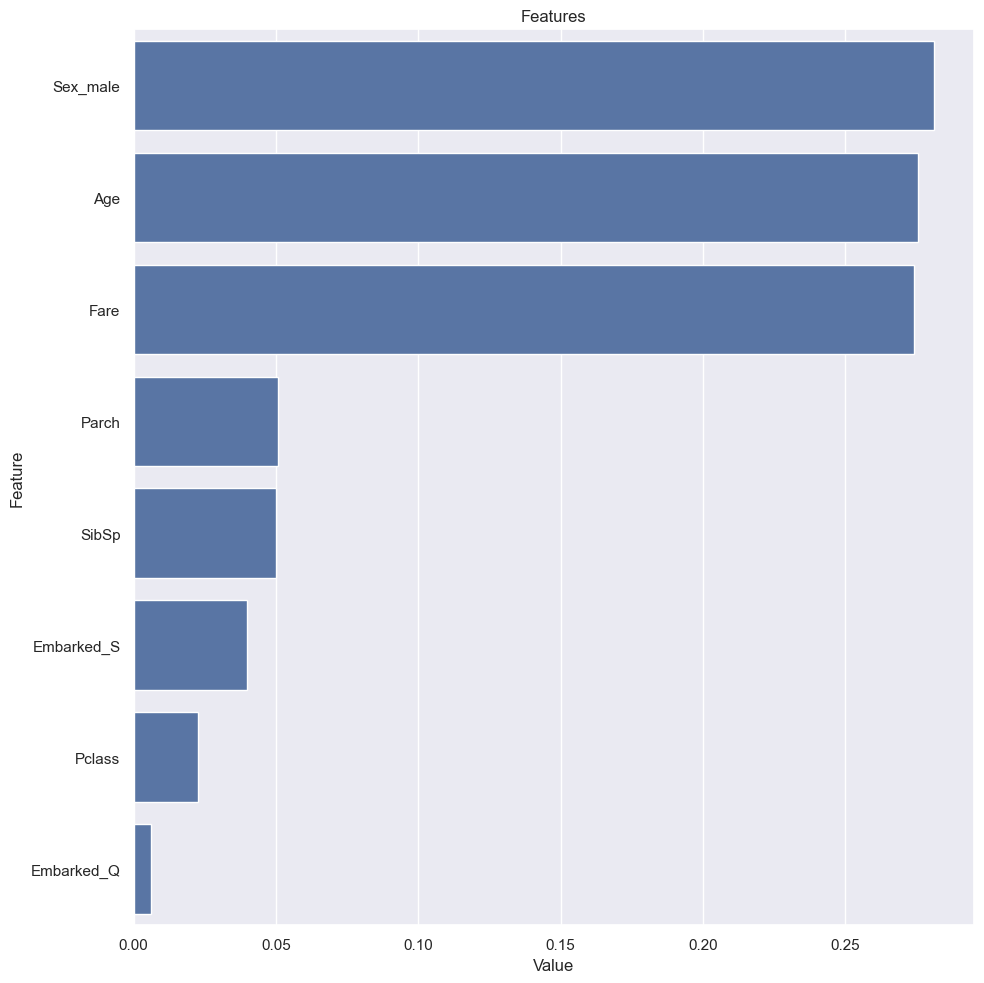

In [42]:
plot_importance(rf_model, X_train)